# Boston Airbnb Listings

## Introduction
In this notebook we will be analysis the Kaggle Dataset provided by Airbnb regarding the listings of different properties in the Boston Area.  This includes a variety of different attributes, including descriptions, number of rooms/beds as well as prices on a nightly, weekly and monthly timeframe.

By going through this we are aiming to ensure that the lessons learnt in the first stage of the Udacity Datacience Nano-Degree are well understood and can apply the learning to diffrerent areas of interest.

## CRISP-DM
Following the CRISP-DM methodology we will be investigating three questions related to this data set.  These are:
* 1. How many times were specific ammenities used in advertisement of property?
* 2. Do these amenities play some impact on the pricing of the property?
* 3. Can we increase the predicted outcome of the nightly price of a dwelling based on the rest of the given dataset?


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

df = pd.read_csv('./Data/listings.csv')

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,4/01/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,4/01/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,4/01/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,4/01/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,4/01/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [2]:
print(df.dtypes)
print(df.shape)

id                                    int64
listing_url                          object
scrape_id                           float64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object
(3818, 92)


Here we can see that the dataset provided is a mixture of integers, floating points and object data types.  We can also see that there are 92 seperate attributes as well as 3818 rows.

### Question 1

In [3]:
amenities = df['amenities'].value_counts().reset_index()
amenities

,index,amenities
0,{},45
1,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",11
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Po...",10
3,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",7
...,...,...
3279,"{TV,""Wireless Internet"",Kitchen,""Elevator in B...",1
3280,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1
3281,"{""Cable TV"",""Wireless Internet"",Kitchen,Heatin...",1
3282,"{Internet,""Wireless Internet"",Pool,Kitchen,Doo...",1


By looking at this data we can see that there are different ways strings are input into the array, specifically with the use of quotation marks.  This could be because of how the input was setup in the backend or used to show an extension of the ammenity.  For example, Internet might be the ammenity and the "Wireless Internet" is the type of internet present in the accomodation.  In order to properly identity the counts of these however it will be necessary to standardise this information so they all are in the same format.

In [4]:
def ammendList(inputList):
    amm = inputList.str.replace('"','').str.replace('{','').str.replace('}','')
    return amm

In [5]:
amenities['index'] = ammendList(amenities['index'])
amenities

,index,amenities
0,,45
1,"Internet,Wireless Internet,Kitchen,Free Parkin...",11
2,"TV,Cable TV,Internet,Wireless Internet,Pool,Ki...",10
3,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",8
4,"TV,Cable TV,Internet,Wireless Internet,Air Con...",7
...,...,...
3279,"TV,Wireless Internet,Kitchen,Elevator in Build...",1
3280,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",1
3281,"Cable TV,Wireless Internet,Kitchen,Heating,Was...",1
3282,"Internet,Wireless Internet,Pool,Kitchen,Doorma...",1


In [6]:
def makeList(concatenatedList):
    '''
    INPUT
        concatenatedList - Series which holds multiple objects as a string
    OUTPUT
        output - unique list of which are used within the concatenatedList
    '''
    
    output = []
    
    for row in concatenatedList:
        x = row.split(',')
        for i in x:
            if i not in output:
                output.append(i)
    return output
    

In [7]:
uniqueList = makeList(ammendList(df['amenities']))
uniqueList.remove('')
uniqueList

['TV',
 'Cable TV',
 'Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Free Parking on Premises',
 'Buzzer/Wireless Intercom',
 'Smoke Detector',
 'Carbon Monoxide Detector',
 'First Aid Kit',
 'Safety Card',
 'Fire Extinguisher',
 'Essentials',
 'Pets Allowed',
 'Pets live on this property',
 'Dog(s)',
 'Cat(s)',
 'Hot Tub',
 'Indoor Fireplace',
 'Shampoo',
 'Breakfast',
 '24-Hour Check-in',
 'Hangers',
 'Hair Dryer',
 'Iron',
 'Laptop Friendly Workspace',
 'Suitable for Events',
 'Elevator in Building',
 'Lock on Bedroom Door',
 'Wheelchair Accessible',
 'Gym',
 'Pool',
 'Smoking Allowed',
 'Other pet(s)',
 'Doorman',
 'Washer / Dryer']

In [8]:
def countOfList(df,col1,col2,lookup):
    '''
    INPUT
        df - dataframe to analyse
        col1 - column to check value against
        col2 - value count column
        lookup - unique list of values
    OUTPUT
        new_df - dataframe showing label and count within input dataframe
    '''
    
    new_df = defaultdict(int)
    for x in lookup:
        for i in range(df.shape[0]):
            if x in df[col1][i]:
                new_df[x]+=int(df[col2][i])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('amenities', ascending=False, inplace=True)
    return new_df
    

In [9]:
amenities_df = countOfList(amenities, 'index','amenities',uniqueList)
amenities_df

,index,amenities
2,Internet,3692
3,Wireless Internet,3667
6,Heating,3627
5,Kitchen,3423
12,Smoke Detector,3281
17,Essentials,3237
9,Dryer,3114
8,Washer,2992
0,TV,2741
24,Shampoo,2670


In [10]:
amenities_df.set_index('index', inplace=True)

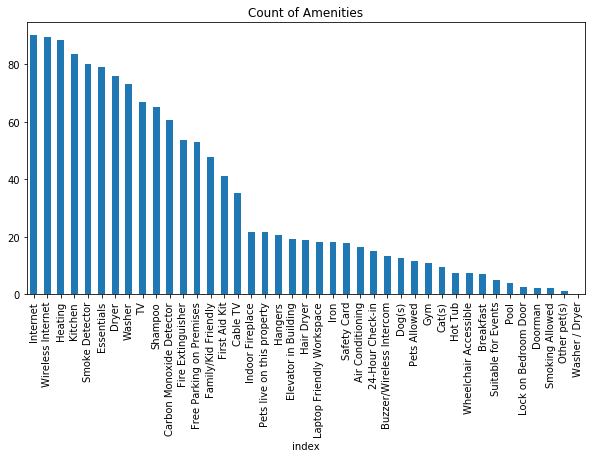

In [11]:
(amenities_df/amenities_df.shape[0]).plot(kind='bar', legend=None, figsize=(10,5));
plt.title("Count of Amenities");
plt.show();

Here we can see that the majority of people who are using Airbnb as a platform to rent out their property believe that things such as Internet and Heating have an impact on their ability to sell the property.  However, this may not be the case.  The next step i understanding the impact these have on the price the property rents out for is to see if we can predict the price based on these attributes.

### Question 2

In [12]:
am_price_df = df[['amenities','price']]
print(am_price_df.dtypes)
am_price_df

amenities    object
price        object
dtype: object


,amenities,price
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",$100.00
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00
...,...,...
3813,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$359.00
3814,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$79.00
3815,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",$93.00
3816,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$99.00


Create a Lambda Expression to remove the price tag from an attribute column to treat the datapoint as a float instaed of a string.

In [13]:
cleanCost = lambda col: col.str.replace(',','').str.replace('$','').astype('float')

In [14]:
am_price_df[['price']] = am_price_df[['price']].apply(cleanCost, axis=0)

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
am_price_df['amenities'] = ammendList(am_price_df['amenities'])
am_price_df

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,amenities,price
0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",85.0
1,"TV,Internet,Wireless Internet,Kitchen,Free Par...",150.0
2,"TV,Cable TV,Internet,Wireless Internet,Air Con...",975.0
3,"Internet,Wireless Internet,Kitchen,Indoor Fire...",100.0
4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",450.0
...,...,...
3813,"TV,Cable TV,Internet,Wireless Internet,Air Con...",359.0
3814,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",79.0
3815,"Cable TV,Wireless Internet,Kitchen,Free Parkin...",93.0
3816,"TV,Wireless Internet,Kitchen,Free Parking on P...",99.0


In [16]:
for col in uniqueList:
    am_price_df[col]=0
    for i in range(am_price_df.shape[0]):
        if col in am_price_df['amenities'][i]:
            am_price_df[col][i]=1
        else:
            am_price_df[col][i]=0

am_price_df.head()

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,amenities,price,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,...,Suitable for Events,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",85.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"TV,Internet,Wireless Internet,Kitchen,Free Par...",150.0,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,"TV,Cable TV,Internet,Wireless Internet,Air Con...",975.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,"Internet,Wireless Internet,Kitchen,Indoor Fire...",100.0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",450.0,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
am_price_df = am_price_df.drop('amenities', axis=1)
am_price_df

,price,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,...,Suitable for Events,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,85.0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,150.0,1,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,975.0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,100.0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,450.0,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,359.0,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
3814,79.0,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3815,93.0,1,1,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3816,99.0,1,0,1,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [18]:
X = am_price_df.drop('price',axis=1)
y = am_price_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.17316384695303666 on 1146 values.'

Here we can see that there is currently not enough information which will allow us to predict the outcome of the price based purely on the amenities.

### Question 3

In [157]:
#clean the prices
df[['price','security_deposit','cleaning_fee']] = df[['price','security_deposit','cleaning_fee']].apply(cleanCost, axis=0)

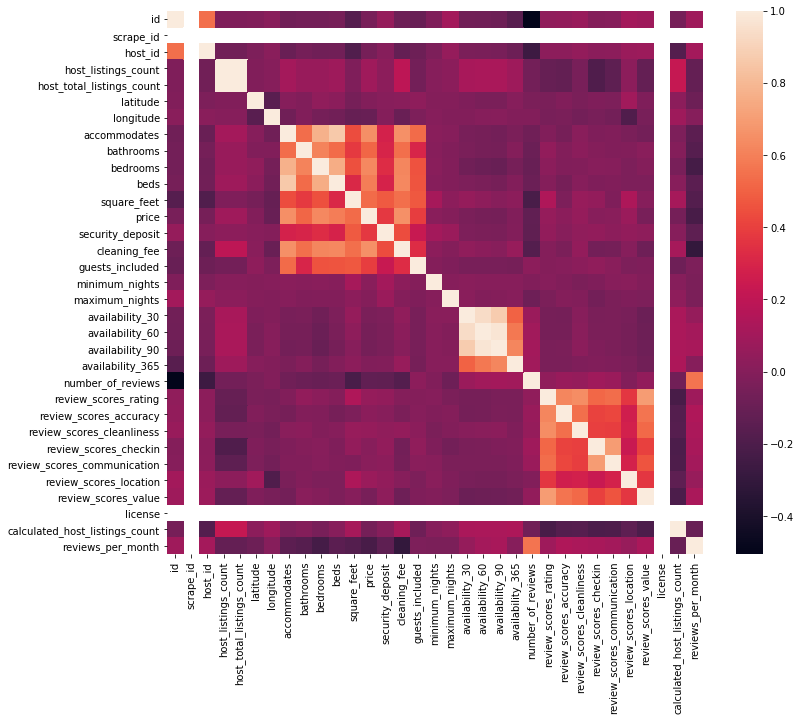

In [158]:
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df.corr(),ax=ax);

In [159]:
df_test = df[['price','accommodates','bathrooms','bedrooms','beds','security_deposit','cleaning_fee','guests_included','neighbourhood_cleansed']]

In [64]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector

    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    
    #Drop respondent and expected salary columns
    df = df.drop('price', axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    #Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        #for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    


In [124]:
def clean_fit_linear_mod(df, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
    
    #Use the function to create X and y
    X, y = clean_data(df)

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [160]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_test, dummy_na=False)

In [161]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.582951773343886.  The rsquared on the test data was 0.5701736316344619.


In [162]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df



In [163]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_test)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
38,neighbourhood_cleansed_Industrial District,104.729625,104.729625
79,neighbourhood_cleansed_Southeast Magnolia,85.533565,85.533565
66,neighbourhood_cleansed_Pioneer Square,79.960186,79.960186
64,neighbourhood_cleansed_Pike-Market,71.042859,71.042859
67,neighbourhood_cleansed_Portage Bay,70.988999,70.988999
89,neighbourhood_cleansed_Westlake,67.719211,67.719211
87,neighbourhood_cleansed_West Queen Anne,58.032086,58.032086
65,neighbourhood_cleansed_Pinehurst,-55.411435,55.411435
44,neighbourhood_cleansed_Lower Queen Anne,47.551601,47.551601
10,neighbourhood_cleansed_Belltown,45.433202,45.433202
